<ipython-input-3-af1246c94901>:63: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type

<ipython-input-3-af1246c94901>:81: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




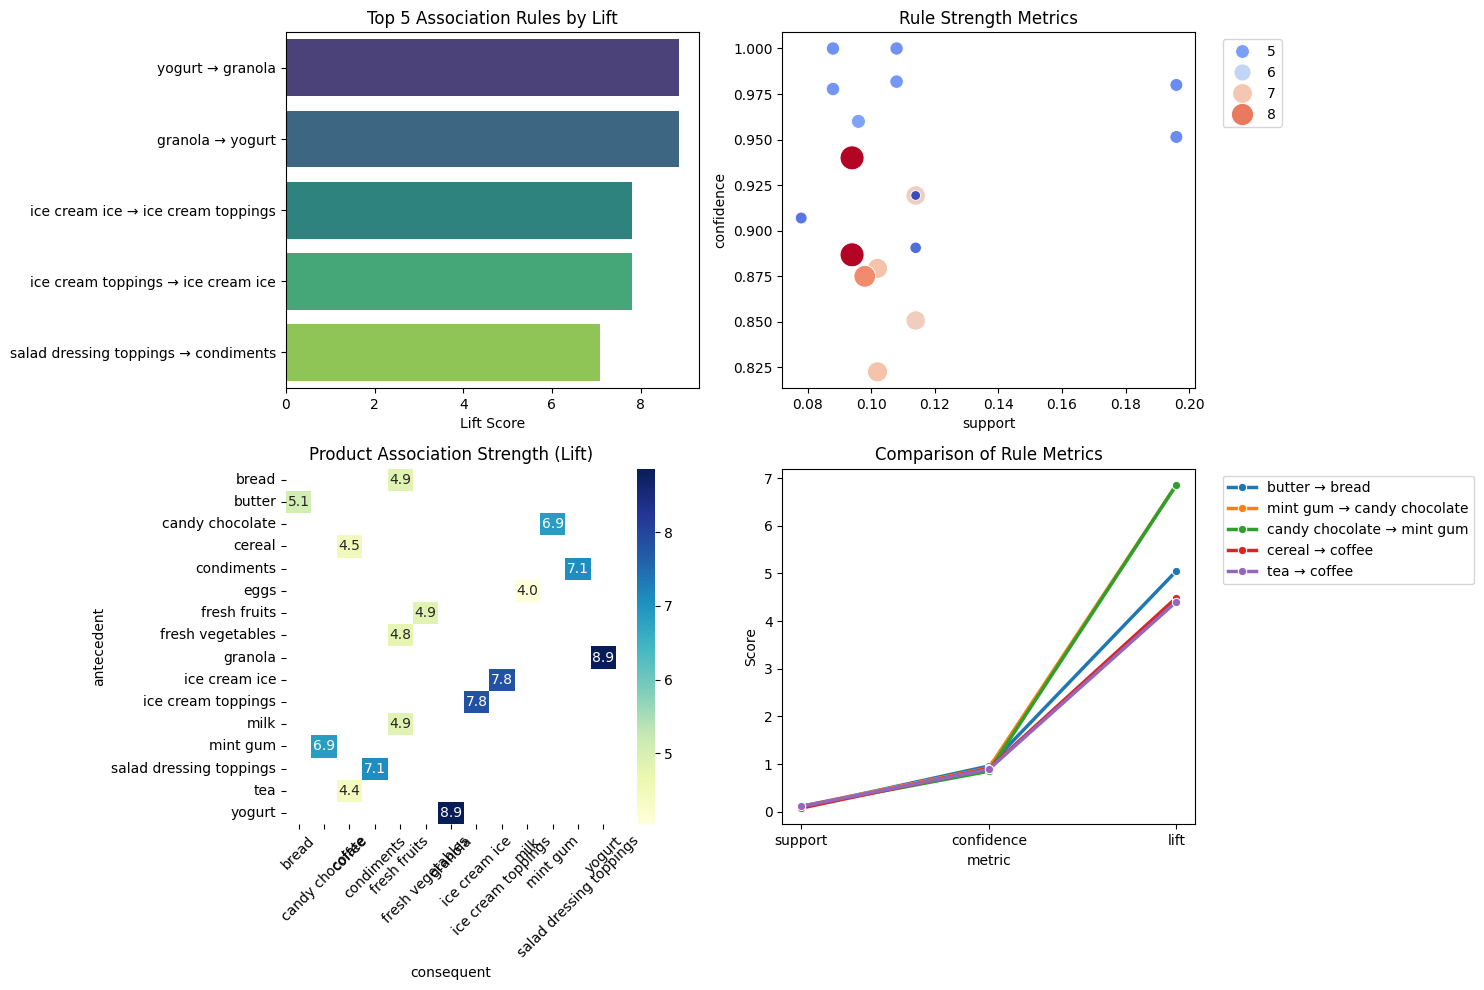

In [3]:
# Install required packages
!pip install mlxtend plotly --upgrade

import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px  # Import plotly.express for scatter plot
from itertools import combinations

# ======================
# 1. DATA PREPARATION
# ======================

# Load your aisle data
aisles = pd.read_csv('10. Market Basket Analysis.csv')

# Generate realistic sample transaction data based on common shopping patterns
np.random.seed(42)
num_transactions = 500

# Create common product groupings that make sense together
common_combinations = [
    [24, 83, 84],       # fruits + vegetables + milk
    [26, 121],          # coffee + cereal
    [112, 36],          # bread + butter
    [120, 57],          # yogurt + granola
    [45, 46],           # candy + gum
    [84, 86],           # milk + eggs
    [24, 83, 112],      # fruits + vegetables + bread
    [26, 94],           # coffee + tea
    [37, 103],          # ice cream + toppings
    [72, 89]            # condiments + salad dressing
]

transactions = []
for i in range(1, num_transactions + 1):
    # Start with a random common combination
    combo = common_combinations[np.random.randint(0, len(common_combinations))]

    # Add 1-3 random additional items
    extra_items = np.random.choice(aisles['aisle_id'],
                                 size=np.random.randint(1, 4),
                                 replace=False)
    basket = list(combo) + list(extra_items)

    for item in basket:
        transactions.append({'transaction_id': i, 'aisle_id': item})

transactions_df = pd.DataFrame(transactions)
transactions_df = transactions_df.merge(aisles, on='aisle_id')

# ======================
# 2. MARKET BASKET ANALYSIS
# ======================

# Prepare basket data
basket = (transactions_df.groupby(['transaction_id', 'aisle'])['aisle']
          .count().unstack().fillna(0)
          .applymap(lambda x: 1 if x > 0 else 0))

# Generate rules
frequent_itemsets = apriori(basket, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
strong_rules = rules[(rules['lift'] >= 1.5) & (rules['confidence'] >= 0.6)]

# ======================
# 3. IMPROVED VISUALIZATIONS
# ======================

plt.figure(figsize=(15, 10))

# 1. Top Rules Bar Chart
plt.subplot(2, 2, 1)
top_rules = strong_rules.sort_values('lift', ascending=False).head(5)
top_rules['rule'] = top_rules.apply(
    lambda x: f"{list(x['antecedents'])[0]} → {list(x['consequents'])[0]}", axis=1)
sns.barplot(x='lift', y='rule', data=top_rules, palette='viridis')
plt.title('Top 5 Association Rules by Lift')
plt.xlabel('Lift Score')
plt.ylabel('')

# 2. Support vs Confidence Scatter Plot
plt.subplot(2, 2, 2)
scatter = sns.scatterplot(
    x='support', y='confidence',
    size='lift', hue='lift',
    sizes=(50, 300), palette='coolwarm',
    data=strong_rules)
plt.title('Rule Strength Metrics')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Antecedent-Consequent Heatmap
plt.subplot(2, 2, 3)
# Prepare data for heatmap
heatmap_data = strong_rules.copy()
heatmap_data['antecedent'] = heatmap_data['antecedents'].apply(lambda x: list(x)[0])
heatmap_data['consequent'] = heatmap_data['consequents'].apply(lambda x: list(x)[0])
heatmap_pivot = heatmap_data.pivot_table(index='antecedent',
                                       columns='consequent',
                                       values='lift',
                                       aggfunc='mean')

sns.heatmap(heatmap_pivot, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Product Association Strength (Lift)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# 4. Rule Metrics Parallel Plot
plt.subplot(2, 2, 4)
parallel_data = strong_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5)
parallel_data['rule'] = parallel_data.apply(
    lambda x: f"{list(x['antecedents'])[0]} → {list(x['consequents'])[0]}", axis=1)
parallel_data = parallel_data.melt(id_vars='rule',
                                 value_vars=['support', 'confidence', 'lift'],
                                 var_name='metric')

sns.lineplot(x='metric', y='value', hue='rule',
             data=parallel_data, marker='o', linewidth=2.5)
plt.title('Comparison of Rule Metrics')
plt.ylabel('Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# ======================
# 4. INTERACTIVE PLOTLY VISUALIZATIONS
# ======================

# Interactive Sankey Diagram using plotly.graph_objects
if len(strong_rules) > 0:
    # Prepare data
    sankey_rules = strong_rules.sort_values('lift', ascending=False).head(5)
    all_labels = []
    for _, rule in sankey_rules.iterrows():
        all_labels.append(list(rule['antecedents'])[0])
        all_labels.append(list(rule['consequents'])[0])
    unique_labels = list(dict.fromkeys(all_labels))

    source = []
    target = []
    value = []
    for _, rule in sankey_rules.iterrows():
        source.append(unique_labels.index(list(rule['antecedents'])[0]))
        target.append(unique_labels.index(list(rule['consequents'])[0]))
        value.append(rule['lift'])

    # Sankey Diagram using plotly.graph_objects
    fig = go.Figure(go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=unique_labels
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        )
    ))

    fig.update_layout(title="Product Association Flow", font_size=10)
    fig.show()

# Interactive Bubble Chart using plotly.express
fig = px.scatter(
    strong_rules, x='support', y='confidence',
    size='lift', color='lift',
    hover_name=strong_rules.apply(
        lambda x: f"{list(x['antecedents'])[0]} → {list(x['consequents'])[0]}", axis=1),
    log_x=True, size_max=60,
    title="Association Rules Explorer"
)
fig.update_layout(showlegend=False)
fig.show()
